Visualize and analyze the model. The fine-tuned model's saliency map is jointly discussed with the emission lines.

Useful links:<br>
[Emision lines web table](https://xdb.lbl.gov/Section1/Periodic_Table/X-ray_Elements.html)<br>
[Dataframe of emission lines](notesbooks/xrf_table.ipynb)<br>
[Introduction to XRF - An Analytical Perspective](https://chem.libretexts.org/Bookshelves/Analytical_Chemistry/Supplemental_Modules_(Analytical_Chemistry)/Analytical_Sciences_Digital_Library/Courseware/Introduction_to_XRF-_An_Analytical_Perspective)

In [73]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from src.datas import transforms
from src.datas.dataloader import get_dataloader
from src.models import mae_vit_regressor
from src.utils.saliency_map import filter_emission_peaks

ev_compile_df = pd.read_csv("files/emission_peaks.csv", index_col=0)

In [81]:
def plot_peaks(min:int, max:int, sa_array, ev_compile_df, elements:list=False, legend:bool=True):
    df = filter_emission_peaks(ev_compile_df, min, max)
    if elements:
        df = df[df["element"].isin(elements)].copy()
    start = int(min*50)
    end = int(max*50)
    ymax=0.65
    
    #fig = plt.figure(figsize=(7, 5))
    # draw soectrum
    plt.plot((np.linspace(1, 2048, 2048) * 0.02)[start:end], sa_array[start:end], c="gray")
    
    # draw ev peaks
    for i, row in enumerate(df.iterrows()):
        row = row[1][row[1] != ""].values
        plt.vlines(row[1:]*0.001, ymin=0, ymax=ymax, label=row[0], colors=f"C{i}", alpha=0.5)

    plt.ylim(0, ymax)
    
    if legend:
        plt.legend()
    plt.xlabel("Energy (KeV)")
    plt.ylabel("Saliency")
    #return fig

# CaCO3

In [2]:
target_task = "CaCO3"
annotation_file = f"data/finetune/{target_task}%/train/info.csv"
input_dir = f"data/finetune/{target_task}%/train/"

target_mean = f"src/datas/xpt_{target_task}_target_mean.pth"
target_std = f"src/datas/xpt_{target_task}_target_std.pth"

finetuned_weight = f"results/finetune_pretrained/pretrain-mask-ratio-0.5-blr-1e-4-transform-instance_normalize/{target_task}/model.ckpt"

device = "cuda"

In [5]:
target_mean = torch.load(target_mean)
target_std = torch.load(target_std)
target_transform = transforms.Normalize(target_mean, target_std)

dataloader = get_dataloader(
    ispretrain=False,
    annotations_file=annotation_file,
    input_dir=input_dir,
    batch_size=56,
    transform=transforms.InstanceNorm(),
    target_transform=target_transform,
    num_workers=1,
    pin_memory=True,
)

In [6]:
model = mae_vit_regressor.mae_vit_base_patch16(pretrained=True,
                                               weights=finetuned_weight)
criterion = torch.nn.MSELoss()

In [7]:
model.eval()
model = model.cuda()

total_saliency_map = torch.empty([0, 2048])
for batch in dataloader["train"]:
    samples = batch["spe"].to(device, non_blocking=True, dtype=torch.float)
    samples.requires_grad = True
    targets = batch["target"].to(device, non_blocking=True, dtype=torch.float)

    preds = model(samples)
    loss = criterion(preds, targets)
    loss.backward()

    saliency_map = samples.grad.data.abs()
    saliency_map /= saliency_map.max(dim=-1)[0].unsqueeze(dim=-1)
    total_saliency_map = torch.concat([total_saliency_map, saliency_map.cpu()], dim=0)

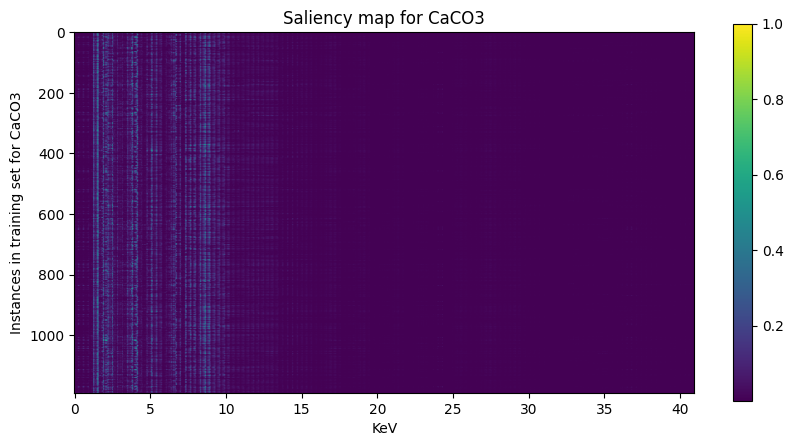

In [8]:
# transform channel to KeV
xticks = np.arange(0, 2048, 250)
xlabels = (xticks*0.02).astype(int)

fig, ax = plt.subplots(figsize=(10, 7))
ax.set_xlabel("KeV")
ax.set_ylabel(f"Instances in training set for {target_task}")
ax.set_title(f"Saliency map for {target_task}")
ax.set_xticks(xticks)
ax.set_xticklabels(xlabels)
cax = ax.imshow(total_saliency_map.cpu().numpy())
cbar = fig.colorbar(cax, ax=ax, orientation='vertical', shrink=0.7)
plt.show()

In [21]:
# take the last batch for further analysis
caco3_sa = saliency_map.cpu().numpy()

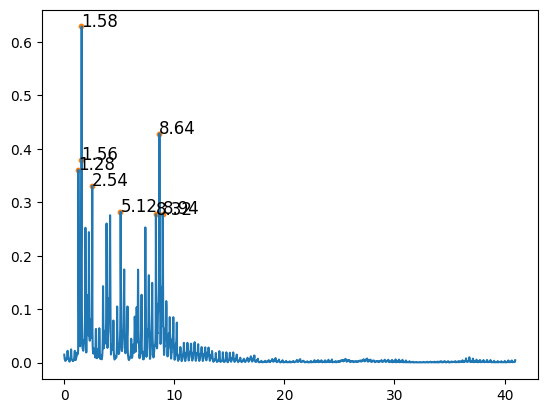

In [106]:
rank = 8

sa_array = caco3_sa.mean(axis=0)
rank_idx = sa_array.argsort()[-rank:]
sa_sort = sa_array[rank_idx]

plt.plot(np.linspace(1, 2048, 2048) * 0.02, sa_array)
plt.scatter(rank_idx * 0.02, sa_sort, c='C1', s=10)

for idx in rank_idx:
    plt.text(idx * 0.02, sa_array[idx], f"{idx*0.02:.2f}", fontsize=12)

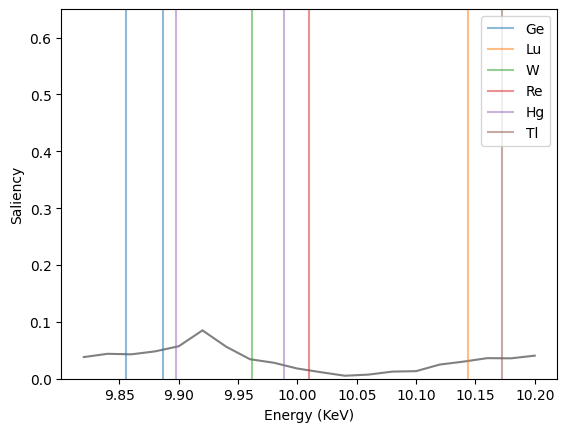

In [107]:
# window search for peak matching
i = 9.8
plot_peaks(min=i, max=i+.4, sa_array=sa_array, ev_compile_df=ev_compile_df)

Mg adn P energy match the saliency map at around 1.3 and 2.13 KeV. Meanwhile, Nb, Ru, Ce, Nd, Sm, Ho, W, Re and Zn also have a high saliency score. Yet these elements should be rare in the elemements so we prefer to interpret them as some artifects.

In [93]:
ev_compile_df[ev_compile_df["element"] == "Ca"]

,Z,element,Ka1,Ka2,Kb1,La1,La2,Lb1,Lb2,Ly1,Ma1
17,20,Ca,3691.68,3688.09,4012.7,341.3,341.3,344.9,NaN,NaN,NaN


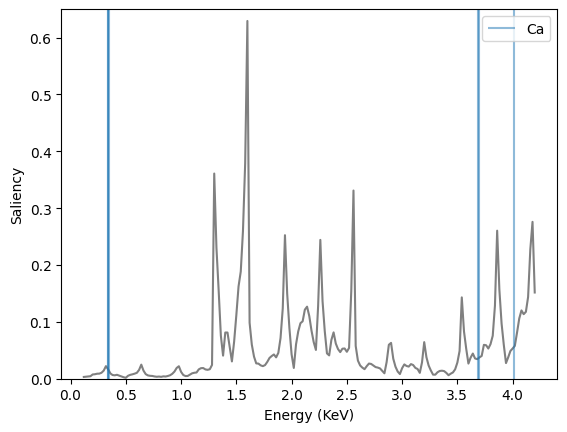

In [108]:
plot_peaks(0.1, 4.2, sa_array, ev_compile_df, ["Ca"])

No clear peak matches Ca, which should be abundance in the samples.

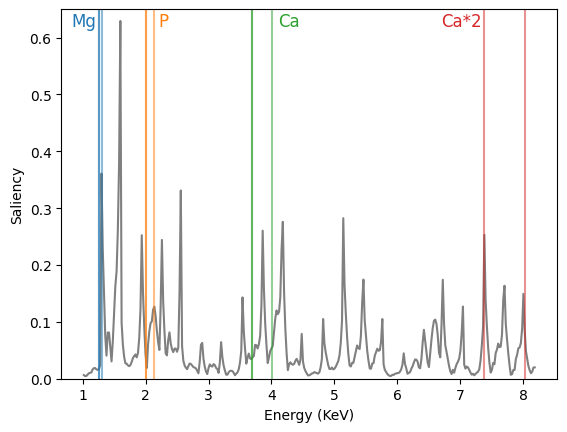

In [111]:
plot_peaks(1, 8.2, sa_array, ev_compile_df, ["Mg", "P", "Ca"], legend=False)
plt.vlines([7.38, 8.02], ymin=0, ymax=0.65, label="Ca*2", colors="C3", alpha=0.5)
i=0
for x, txt in zip([0.82, 2.2, 4.1, 6.7], ["Mg", "P", "Ca", "Ca*2"]):
    plt.text(x, 0.62, txt, fontsize=12, c=f"C{i}")
    i+=1

We found our model taking Mg and P as important contributing elements. Mg is commonly coexist with Ca in carbonates. I still need to check P. The orginal Ca energy does not match the saliency peaks. However, we can find matches at twice of the original Ca energy, which implies the sum peaks effect. Two Ca photons hit the detector almost at the same time, which is possible in spectra that have high concentration of Ca. The peaks also match with the energy of rare elements, like Nb, Ru, Ce, Nd, Sm, Ho, W, Re and Zn. We prefer to interprete them as artifects. There are still many saliency peaks remain unexplained, which is worthy of further investigation.



# TOC

In [74]:
target_task = "TOC"
annotation_file = f"data/finetune/{target_task}%/train/info.csv"
input_dir = f"data/finetune/{target_task}%/train/"

target_mean = f"src/datas/xpt_{target_task}_target_mean.pth"
target_std = f"src/datas/xpt_{target_task}_target_std.pth"

finetuned_weight = f"results/finetune_pretrained/pretrain-mask-ratio-0.5-blr-1e-4-transform-instance_normalize/{target_task}/model.ckpt"

device = "cuda"

In [75]:
target_mean = torch.load(target_mean)
target_std = torch.load(target_std)
target_transform = transforms.Normalize(target_mean, target_std)

dataloader = get_dataloader(
    ispretrain=False,
    annotations_file=annotation_file,
    input_dir=input_dir,
    batch_size=56,
    transform=transforms.InstanceNorm(),
    target_transform=target_transform,
    num_workers=1,
    pin_memory=True,
)

In [76]:
model = mae_vit_regressor.mae_vit_base_patch16(pretrained=True,
                                               weights=finetuned_weight)
criterion = torch.nn.MSELoss()

In [77]:
model.eval()
model = model.cuda()

total_saliency_map = torch.empty([0, 2048])
for batch in dataloader["train"]:
    samples = batch["spe"].to(device, non_blocking=True, dtype=torch.float)
    samples.requires_grad = True
    targets = batch["target"].to(device, non_blocking=True, dtype=torch.float)

    preds = model(samples)
    loss = criterion(preds, targets)
    loss.backward()

    saliency_map = samples.grad.data.abs()
    saliency_map /= saliency_map.max(dim=-1)[0].unsqueeze(dim=-1)
    total_saliency_map = torch.concat([total_saliency_map, saliency_map.cpu()], dim=0)

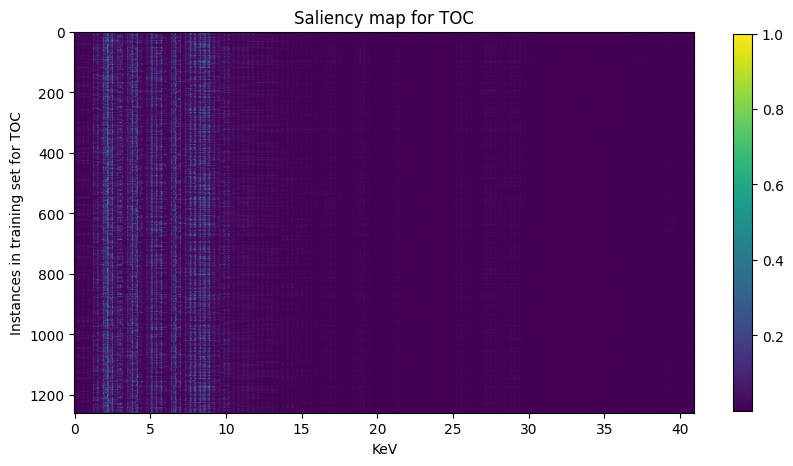

In [77]:
# transform channel to KeV
xticks = np.arange(0, 2048, 250)
xlabels = (xticks*0.02).astype(int)

fig, ax = plt.subplots(figsize=(10, 7))
ax.set_xlabel("KeV")
ax.set_ylabel(f"Instances in training set for {target_task}")
ax.set_title(f"Saliency map for {target_task}")
ax.set_xticks(xticks)
ax.set_xticklabels(xlabels)
cax = ax.imshow(total_saliency_map.cpu().numpy())
cbar = fig.colorbar(cax, ax=ax, orientation='vertical', shrink=0.7)
plt.show()

In [78]:
toc_sa = saliency_map.cpu().numpy()

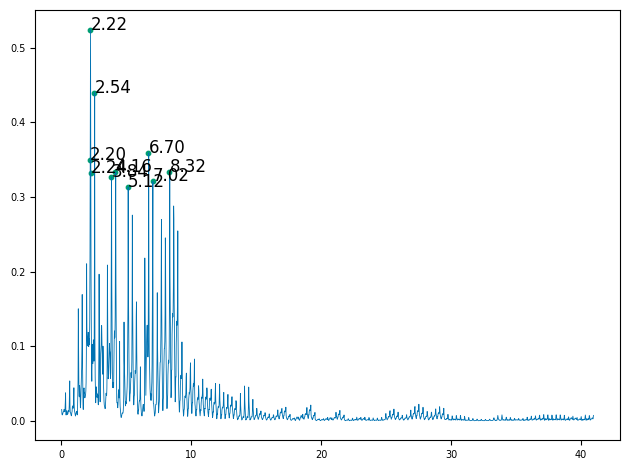

In [79]:
rank = 10
sa_array = toc_sa.mean(axis=0)
rank_idx = sa_array.argsort()[-rank:]
sa_sort = sa_array[rank_idx]

plt.plot(np.linspace(1, 2048, 2048) * 0.02, sa_array)
plt.scatter(rank_idx * 0.02, sa_sort, c='C1', s=10)

for idx in rank_idx:
    plt.text(idx * 0.02, sa_array[idx], f"{idx*0.02:.2f}", fontsize=12)

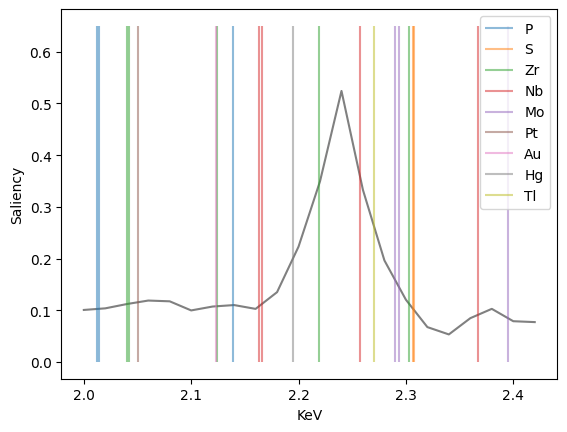

In [231]:
# search for peak matching
i = 2
plot_peaks(min=i, max=i+.4, sa_array=sa_array, ev_compile_df=ev_compile_df)

In [117]:
ev_compile_df[ev_compile_df["element"] == "Rb"]

,Z,element,Ka1,Ka2,Kb1,La1,La2,Lb1,Lb2,Ly1,Ma1
34,37,Rb,13395.3,13335.8,14961.3,1694.13,1692.56,1752.17,NaN,NaN,NaN


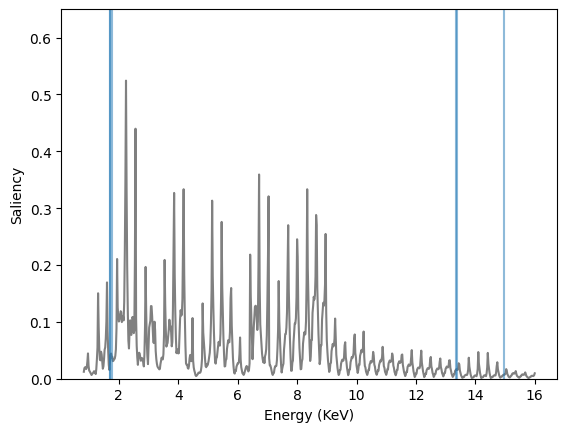

In [121]:
plot_peaks(min=0.8, max=16, sa_array=sa_array, ev_compile_df=ev_compile_df, elements=["Rb"], legend=False)

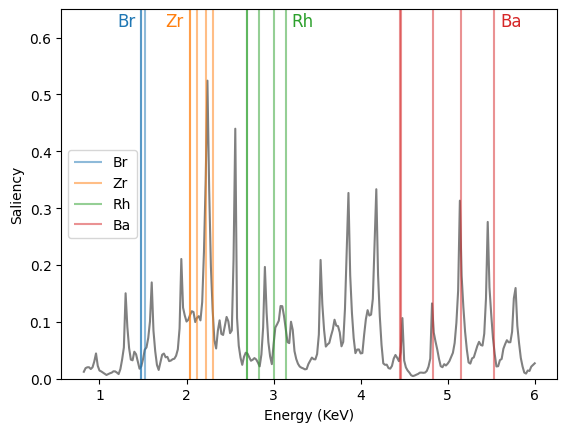

In [128]:
elements = ["Br", "Zr", "Rh","Ba"]
plot_peaks(min=0.8, max=6, sa_array=sa_array, ev_compile_df=ev_compile_df, elements=elements)
i=0
for x, txt in zip([1.2, 1.76, 3.2, 5.6], elements):
    plt.text(x, 0.62, txt, fontsize=12, c=f"C{i}")
    i+=1

I found saliency peaks match with the energy of Zr, Ba, Rh and other rare elements which I interpret as artifects (Dy, Ru, Ho, W, Zn). The Zr implies the grain size (?). Rb, which is often used as the denominator of Zr as the proxy of grain size, doesn't match any saliency peaks. It may indicate the model finds some other part of spectrum as the calibration replacing Rb. Ba is often considered the proxy of deep sea productivity ([ref1](https://cp.copernicus.org/articles/6/63/2010/cp-6-63-2010-discussion.html) and [ref2](https://www.sciencedirect.com/science/article/pii/S0012821X08006754?via%3Dihub)) so reasonable to be the indicator of TOC. Two of the Rh energy lines (2.83 and 3.00) have some offsets to the saliency peaks. This could indicate the model is taking the inelastic scattering of the X-ray tube source (Rh) photons into account, which is also called Compton peaks. This artifect is often seen in the low density samples and thus treated as indirect TOC proxy.  
The commonly used marine TOC proxy, Br, doesn't match any saliency peaks. It could indicate this proxy's low effecttiveness due to the samples' low concentration of TOC. The model rather depends on other parts of spectrum to jointly calibrate this diffcult task.

## Join the figures

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


from src.utils.saliency_map import filter_emission_peaks
from src.utils.saliency_map import generate_saliency_map

In [2]:
min = 1
max = 8.2

sa_dict = {
    "CaCO3": generate_saliency_map("CaCO3"),
    "TOC": generate_saliency_map("TOC")       
           }

elements_dict = {
    "CaCO3": ["Mg", "P", "Ca", "Ba"],
    "TOC": ["Br", "Zr", "Rh", "Ba"]
    }

ev_compile_df = pd.read_csv("files/emission_peaks.csv", index_col=0)
df = filter_emission_peaks(ev_compile_df, min, max)

In [9]:
plt.style.use("seaborn-v0_8-colorblind")
plt.rcParams["savefig.dpi"] = 300
plt.rcParams["axes.labelsize"] = 9
plt.rcParams["xtick.labelsize"] = 7
plt.rcParams["ytick.labelsize"] = 7
plt.rcParams["legend.fontsize"] = 7

plt.rcParams["lines.linewidth"] = 0.6
plt.rcParams["lines.markersize"] = 1.5
plt.rcParams["figure.autolayout"] = True

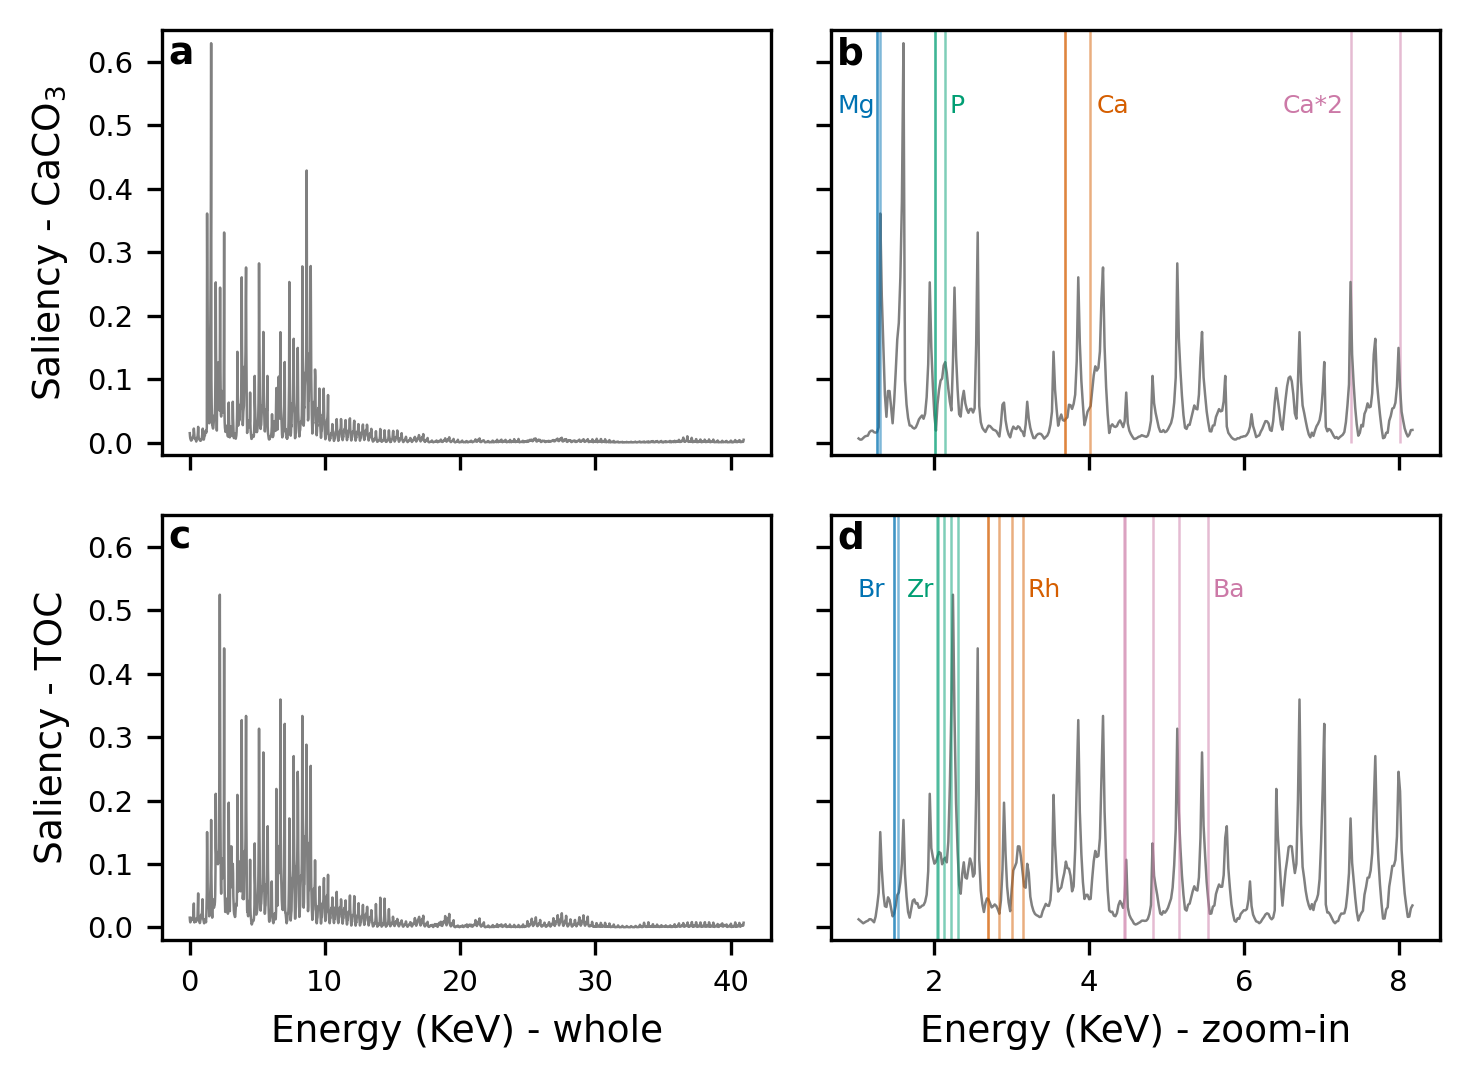

In [86]:
elements_dict = {
    "CaCO3": ["Mg", "P", "Ca"],
    "TOC": ["Br", "Zr", "Rh", "Ba"]
    }
def plot(df, sa_dict, elements_dict):    
    start = int(min*50)
    end = int(max*50)
    ymin = -0.02
    ymax = 0.65
    kev = np.linspace(1, 2048, 2048) * 0.02

    fig, axes = plt.subplots(2, 2, figsize=(5, 3.7), sharey="row", sharex="col", tight_layout=True, dpi=300)
    for ax_row, target in enumerate(["CaCO3", "TOC"]):
        sa_array = sa_dict[target]
        elements = elements_dict[target]
        
        label_y = 0.52
        i=0
        if target == "CaCO3":
            axes[0, 1].vlines([7.38, 8.02], ymin=0, ymax=0.65, colors="C3", alpha=0.5)
            for label_x, txt in zip([0.75, 2.2, 4.1, 6.5], ["Mg", "P", "Ca", "Ca*2"]):
                axes[0, 1].text(label_x, label_y, txt, fontsize=6, c=f"C{i}")
                i += 1

        elif target == "TOC":
            for label_x, txt in zip([1, 1.64, 3.2, 5.6], elements):
                axes[1, 1].text(label_x, label_y, txt, fontsize=6, c=f"C{i}")
                i += 1

        # draw the whole saliency map
        axes[ax_row, 0].plot(kev, sa_array, label="whole map", c="gray")

        # draw zoom-in saliency map
        axes[ax_row, 1].plot(kev[start:end], sa_array[start:end], c="gray", label="zoom-in map") 

        df_tmp = df[df["element"].isin(elements)].copy()

        # draw ev peaks
        for i, row in enumerate(df_tmp.iterrows()):
            row = row[1][row[1] != ""].values
            axes[ax_row, 1].vlines(row[1:]*0.001, ymin=ymin, ymax=ymax,
                        label=row[0], colors=f"C{i}", alpha=0.5)

        axes[ax_row, 1].set_ylim(ymin, ymax)
        #axes[ax_row, 1].legend()



    axes[1, 0].set_xlabel("Energy (KeV) - whole")
    axes[1, 1].set_xlabel("Energy (KeV) - zoom-in")
    axes[0, 0].set_ylabel("Saliency - CaCO$_3$")
    axes[1, 0].set_ylabel("Saliency - TOC")

    for ax, index in zip(axes.ravel(), ["a", "b", "c", "d"]):
            ax.text(0.01, 0.92,
                index, transform=ax.transAxes, fontsize=9, weight="bold")#, color="#53585F")
            
plot(df, sa_dict, elements_dict)